In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas    : 1.1.5
numpy     : 1.20.1
matplotlib: 3.3.4
seaborn   : 0.11.1



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import PredefinedSplit

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df_type_1_features = pd.read_csv("../data/strains.dataset.tree.csv", index_col=0)

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (73,86,98,99,103,106,107,111,112,204,217,229,230,234,237,238,242,243) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')
CV = PredefinedSplit(df_type_1_features['dataset_cat'].cat.codes)

In [6]:
for name, group in df_type_1_features.groupby('dataset'):
    print(len(group['assembly_accession'].unique()))

15921
18806
21665
21036
13506
16495
16662


In [7]:
df_type_1_features['truth'].sum() / df_type_1_features.shape[0]

0.0009831494628941664

In [8]:
list(df_type_1_features.columns)

['assembly_accession',
 'tree_closest_assembly_accession',
 'tree_dist',
 'tree_top_dist',
 'hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_padded_coverage',
 'mean_padded_coverage',
 'sd_padded_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_padded_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'gf_accession',
 'gf_ambiguous_bases',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'gf_checkm_marker_count',
 'gf_checkm_marker_lineage',
 'gf_checkm_marker_set_count',
 'gf_checkm_strain_heterogeneity',
 'gf_coding_bases',
 'gf_coding_density',
 'gf_contig_count',
 'gf_gc_count',
 'gf_gc_percentage',
 'gf_genome_size',
 'gf_gtdb_genome_representative',
 'gf_gtdb_representative',
 'gf_gtdb_taxonomy',
 'gf_gtdb_type_desig

In [9]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'tree_dist',
 'tree_top_dist',
 'gf_checkm_completeness',
 'gf_checkm_contamination'
]

In [10]:
X_type_1 = df_type_1_features[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]
                                                 
X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
X_type_1 = X_type_1.dropna()

print(X_type_1.groupby('dataset').sum())

y = X_type_1["truth"]
X = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "dataset_cat", "truth"])]

X_type_1.to_csv("../data/type_1.extra.tree.csv", index=False)

                    hits  percent_coverage  mean_coverage    sd_coverage  \
dataset                                                                    
dual_index       1734304         28.062051      88.341678     840.304259   
gis_20         361319935         40.965084   11045.607897  214833.055608   
hmp_even        26120868         48.138912     588.211176   14515.805304   
hmp_staggered   13987473         23.541141     275.052218    9609.165257   
mbarc_26        89680807         32.067000    6017.729981   16506.313587   
zymo_even       10317373         19.231281     485.308514    5010.760035   
zymo_log       133887236         13.417510    4209.986755   65399.745693   

               percent_binned_coverage  mean_binned_coverage  \
dataset                                                        
dual_index                     45.7004              173.4298   
gis_20                         69.4328            36131.9216   
hmp_even                      100.7977             2612.079

In [11]:
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
rfc = RandomForestClassifier(n_estimators=100, max_features=.2, min_samples_leaf=17, min_samples_split=9, bootstrap=False, criterion="gini", class_weight="balanced")

logistic = LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")

min_features_to_select = 5

In [13]:
rfecv = RFECV(rfc, step=1, cv=CV, scoring="f1", min_features_to_select=min_features_to_select, n_jobs=40)

In [14]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [15]:
rfecv.fit(X, y)

RFECV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 1, 1])),
      estimator=RandomForestClassifier(bootstrap=False, class_weight='balanced',
                                       max_features=0.2, min_samples_leaf=17,
                                       min_samples_split=9),
      min_features_to_select=5, n_jobs=40, scoring='f1')

In [16]:
rfecv.transform(X)

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[9.60000000e+01, 1.71595733e-05, 7.10437693e-01, ...,
        4.60000000e-02, 2.00000000e+00, 3.90422500e+06],
       [2.00000000e+01, 3.41750416e-04, 4.13717990e-01, ...,
        4.30000000e-02, 1.00000000e+00, 2.02284400e+06],
       [9.70000000e+01, 9.12636080e-05, 3.36073526e-01, ...,
        4.70000000e-02, 1.00000000e+00, 3.54738900e+06],
       ...,
       [2.00000000e+01, 1.42146210e-04, 3.12217588e-01, ...,
        2.50000000e-02, 1.00000000e+00, 1.41293700e+06],
       [0.00000000e+00, 2.08775914e-02, 3.69864685e-01, ...,
        1.62000000e-01, 3.00000000e+00, 4.10605300e+06],
       [2.00000000e+01, 1.26640733e-04, 5.80128200e-01, ...,
        1.40000000e-02, 2.00000000e+00, 3.58367100e+06]])

In [17]:
X.columns[rfecv.ranking_ == 1]

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['consecutive_ns', 'expected_percent_coverage', 'gc_content',
       'gf_checkm_completeness', 'gf_checkm_contamination', 'hits',
       'largest_binned_pileup', 'largest_pileup', 'mean_binned_coverage',
       'mean_coverage', 'num_n_groups', 'percent_binned_coverage',
       'percent_coverage', 'percent_max_uncovered_region',
       'sd_binned_coverage', 'sd_coverage', 'shannon_entropy',
       'total_genome_length', 'tree_dist', 'tree_top_dist',
       'ungapped_genome_length'],
      dtype='object')

Optimal number of features : 21


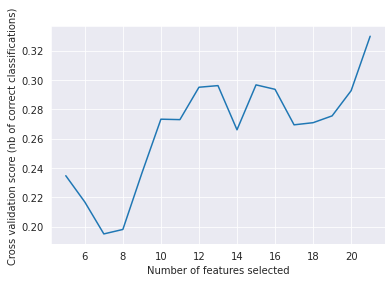

In [18]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [19]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')
cv = PredefinedSplit(df_type_1_features['dataset_cat'].cat.codes)
classifier = rfc

categories = df_type_1_features['dataset_cat'].cat.categories

X = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "dataset_cat", "truth"])]
X = rfecv.transform(X)

precisions = []
average_precisions = []
mean_recall = np.linspace(0, 1, 100)
classifiers = []

for i, (train, test) in enumerate(CV.split(X, y)):
    clf = RandomForestClassifier(n_estimators=100, max_features=.2, min_samples_leaf=17, min_samples_split=9, bootstrap=False, criterion="gini", class_weight="balanced_subsample")
    clf.fit(X[train], y[train])
    classifiers.append(clf)

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
X

array([[9.60000000e+01, 1.71595733e-05, 7.10437693e-01, ...,
        4.60000000e-02, 2.00000000e+00, 3.90422500e+06],
       [2.00000000e+01, 3.41750416e-04, 4.13717990e-01, ...,
        4.30000000e-02, 1.00000000e+00, 2.02284400e+06],
       [9.70000000e+01, 9.12636080e-05, 3.36073526e-01, ...,
        4.70000000e-02, 1.00000000e+00, 3.54738900e+06],
       ...,
       [2.00000000e+01, 1.42146210e-04, 3.12217588e-01, ...,
        2.50000000e-02, 1.00000000e+00, 1.41293700e+06],
       [0.00000000e+00, 2.08775914e-02, 3.69864685e-01, ...,
        1.62000000e-01, 3.00000000e+00, 4.10605300e+06],
       [2.00000000e+01, 1.26640733e-04, 5.80128200e-01, ...,
        1.40000000e-02, 2.00000000e+00, 3.58367100e+06]])

Dataset: dual
F1: 0.44444444444444436
Precision: 0.3181818181818182
Recall: 0.7368421052631579
Num Predicted: 44
Dataset: gis
F1: 0.23214285714285712
Precision: 0.13978494623655913
Recall: 0.6842105263157895
Num Predicted: 93
Dataset: hmp
F1: 0.21739130434782605
Precision: 0.13297872340425532
Recall: 0.5952380952380952
Num Predicted: 188
Dataset: mbarc
F1: 0.3
Precision: 0.42857142857142855
Recall: 0.23076923076923078
Num Predicted: 14
Dataset: zymo
F1: 0.360655737704918
Precision: 0.24444444444444444
Recall: 0.6875
Num Predicted: 45


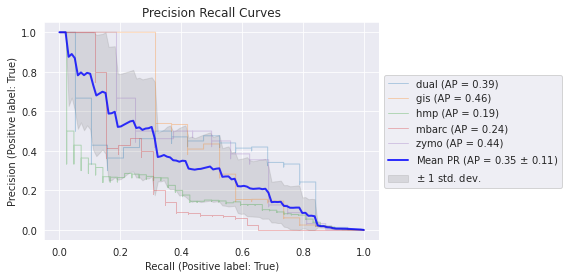

In [22]:
fig, ax = plt.subplots()
for i, ((train, test), classifier) in enumerate(zip(CV.split(X, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X[test], y[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y[test], y_pred)}")
    print(f"Precision: {precision_score(y[test], y_pred)}")
    print(f"Recall: {recall_score(y[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [23]:
# #import the required library
# from numpy import argmax

# # Calculate F-Scores and find the index of ideal score
# fscore = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
# ix = argmax(fscore)
# best_thresh = thresholds[ix]
# print('Best Threshold: %f' % (best_thresh))

/home/bhillmann/.conda/envs/tpot-cuml/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
